In [1]:
# Copyright 2019 Steven Mattis and Troy Butler

import numpy as np
import matplotlib.pyplot as plt
import dynamical_systems as ds
from scipy.stats import gaussian_kde as GKDE
from math import *
from luq import *

The model is the Sel'kov model for glycolysis, a process by which living cells breakdown sugar to obtain energy:
$$x' = -(x+b) + a \left(y + \frac{b}{a+b^2} \right) + (x+b)^2 \left(y + \frac{b}{a+b^2}\right)$$
$$y' = b-a\left(y+ \frac{b}{a+b^2}\right) - (x+b)^2 \left(y + \frac{b}{a+b^2}\right), $$
where $x$ and $y$ represent concentrations of ADP and F6P, respectively, and $a,b>0$.
The initial conditions are $x(0) = x_0 \in \mathbb{R}$ and $y(0) = y_0 \in \mathbb{R}$.

The system has Hopf Bifurcations at 
$$b = b_1(a) = \sqrt{(1-\sqrt{1-8a}-2a)/2}$$
and
$$b = b_2(a) = \sqrt{(1+\sqrt{1-8a}-2a)/2}.$$
If $b<b_1$, the origin is a stable focus. If $b_1 < b < b_2$, there is a stable periodic orbit.
If $b > b_2$ the origin is a stable focus.

The system is solved numerically using the RK45 method.

A ***true*** distribution of $a, b,  x_0$, and $y_0$ are defined by (non-uniform)
Beta distributions and used to generate a set of time series data.

An ***initial*** uniform distribution is assumed and updated by the true time series data.

In [2]:
# Uniformly sample the parameter samples to form a "prediction" or "test" set
num_samples = int(1E3)

param_range = np.array([[0.01, 0.12], # a
                       [0.05, 1.5]])  #b
ic_range = np.array([[0.5, 2.0],  # y_0
                     [0.5, 2.0]])  # x_0

params = np.random.uniform(size=(num_samples, 2))
params = param_range[:, 0] + (param_range[:, 1] - param_range[:, 0]) * params

ics = np.random.uniform(size=(num_samples, 2))
ics = ic_range[:, 0] + (ic_range[:, 1] - ic_range[:, 0]) * ics

# labels
param_labels = [r'$a$', r'$b$']
ic_labels = [r'$x_0$', r'$y_0$']

# Construct the predicted time series data
num_time_preds = int(1000)  # number of predictions (uniformly space) between [time_start,time_end]
time_start = 0.5
time_end = 40.0
times = np.linspace(time_start, time_end, num_time_preds)

# Solve systems
phys = ds.Selkov()
predicted_time_series = phys.solve(ics=ics, params=params, t_eval=times)

In [3]:
# Simulate an observed Beta distribution of time series data

num_obs = int(1E3)

true_a = 2
true_b = 2

params_obs = np.random.beta(size=(num_obs, 2), a=true_a, b=true_b)
params_obs = param_range[:, 0] + (param_range[:, 1] - param_range[:, 0]) * params_obs

ics_obs = np.random.beta(size=(num_obs, 2), a=true_a, b=true_b)
ics_obs = ic_range[:, 0] + (ic_range[:, 1] - ic_range[:, 0]) * ics_obs

# Solve system
observed_time_series = phys.solve(ics=ics_obs, params=params_obs, t_eval=times)

# Add noise if desired
with_noise = False
noise_stdev = 0.05

if with_noise:
    observed_time_series += noise_stdev * np.random.randn(num_obs)

In [4]:
# Use LUQ to learn dynamics and QoIs
learn = LUQ(predicted_time_series, observed_time_series, times)

# time array indices over which to use
time_start_idx = 500
time_end_idx = 799

# Clean data
learn.clean_data(time_start_idx=time_start_idx, time_end_idx=time_end_idx,
                 num_clean_obs=100, tol=3.0e-2, min_knots=15, max_knots=40)

0 16 0.0029510263159747423
0 16 knots being used with error of 0.0029510263159747423
1 16 0.012120754986716845
1 16 knots being used with error of 0.012120754986716845
2 16 0.003006980043187849
2 16 knots being used with error of 0.003006980043187849
3 16 0.0026562757937078963
3 16 knots being used with error of 0.0026562757937078963
4 16 0.01690769545477198
4 16 knots being used with error of 0.01690769545477198
5 16 0.02051888254261356
5 16 knots being used with error of 0.02051888254261356
6 16 0.018562095063292074
6 16 knots being used with error of 0.018562095063292074
7 16 0.018668206777997565
7 16 knots being used with error of 0.018668206777997565
8 16 0.003362544171086392
8 16 knots being used with error of 0.003362544171086392
9 16 0.010429999830043656
9 16 knots being used with error of 0.010429999830043656
10 16 0.013902416578535092
10 16 knots being used with error of 0.013902416578535092
11 16 0.003703980960369787
11 16 knots being used with error of 0.003703980960369787


/Users/smattis/src/anaconda3/anaconda3/envs/loq.py/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


61 16 0.01662382987150063
61 16 knots being used with error of 0.01662382987150063
62 16 0.018825746221549935
62 16 knots being used with error of 0.018825746221549935
63 16 0.02324624755537363
63 16 knots being used with error of 0.02324624755537363
64 16 0.017434197268740608
64 16 knots being used with error of 0.017434197268740608
65 16 0.0125237020697741
65 16 knots being used with error of 0.0125237020697741
66 16 0.006124476358028103
66 16 knots being used with error of 0.006124476358028103
67 16 0.00036885813270271135
67 16 knots being used with error of 0.00036885813270271135
68 16 0.0021640872821149714
68 16 knots being used with error of 0.0021640872821149714
69 16 0.011082104768810235
69 16 knots being used with error of 0.011082104768810235
70 16 0.019729975700470078
70 16 knots being used with error of 0.019729975700470078
71 16 0.02636330490306594
71 16 knots being used with error of 0.02636330490306594
72 16 0.017961028784926857
72 16 knots being used with error of 0.017

155 16 0.0021593570214118035
155 16 knots being used with error of 0.0021593570214118035
156 16 0.008964687086245959
156 16 knots being used with error of 0.008964687086245959
157 16 0.0035163612147720486
157 16 knots being used with error of 0.0035163612147720486
158 16 0.016357986115003
158 16 knots being used with error of 0.016357986115003
159 16 0.0022506843113355973
159 16 knots being used with error of 0.0022506843113355973
160 16 0.015790016574132815
160 16 knots being used with error of 0.015790016574132815
161 16 0.0025693538508614897
161 16 knots being used with error of 0.0025693538508614897
162 16 0.015764660496328717
162 16 knots being used with error of 0.015764660496328717
163 16 0.012473602689145337
163 16 knots being used with error of 0.012473602689145337
164 16 0.0032063534990465505
164 16 knots being used with error of 0.0032063534990465505
165 16 0.011516131249477335
165 16 knots being used with error of 0.011516131249477335
166 16 0.05212768090121886
166 17 0.041

248 16 1.4612373198458819e-05
248 16 knots being used with error of 1.4612373198458819e-05
249 16 0.023489741400796658
249 16 knots being used with error of 0.023489741400796658
250 16 0.025756501153821405
250 16 knots being used with error of 0.025756501153821405
251 16 0.002330937087235724
251 16 knots being used with error of 0.002330937087235724
252 16 0.01247972772240547
252 16 knots being used with error of 0.01247972772240547
253 16 0.00134167468616688
253 16 knots being used with error of 0.00134167468616688
254 16 0.01438920715469981
254 16 knots being used with error of 0.01438920715469981
255 16 0.018021738621426864
255 16 knots being used with error of 0.018021738621426864
256 16 0.013428332356862497
256 16 knots being used with error of 0.013428332356862497
257 16 0.013206103474361821
257 16 knots being used with error of 0.013206103474361821
258 16 3.4074152677065075e-05
258 16 knots being used with error of 3.4074152677065075e-05
259 16 0.013413503302297295
259 16 knots 

343 16 0.01536155319244802
343 16 knots being used with error of 0.01536155319244802
344 16 0.004468737098446976
344 16 knots being used with error of 0.004468737098446976
345 16 0.009648181753715636
345 16 knots being used with error of 0.009648181753715636
346 16 0.0046937797808338155
346 16 knots being used with error of 0.0046937797808338155
347 16 1.998724766199768e-05
347 16 knots being used with error of 1.998724766199768e-05
348 16 0.02423942557604443
348 16 knots being used with error of 0.02423942557604443
349 16 0.014771598921361723
349 16 knots being used with error of 0.014771598921361723
350 16 0.012496902188111338
350 16 knots being used with error of 0.012496902188111338
351 16 0.005857988857454503
351 16 knots being used with error of 0.005857988857454503
352 16 0.021963394318952112
352 17 0.021250490214449438
352 17 knots being used with error of 0.021250490214449438
353 16 0.006431131400657555
353 16 knots being used with error of 0.006431131400657555
354 16 0.018962

435 16 0.01318194403823555
435 16 knots being used with error of 0.01318194403823555
436 16 0.0021356346851738083
436 16 knots being used with error of 0.0021356346851738083
437 16 0.03187274529703396
437 16 knots being used with error of 0.03187274529703396
438 16 0.017341120816478334
438 16 knots being used with error of 0.017341120816478334
439 16 0.0003066342158347015
439 16 knots being used with error of 0.0003066342158347015
440 16 0.0316313390271536
440 16 knots being used with error of 0.0316313390271536
441 16 0.02973519413643771
441 16 knots being used with error of 0.02973519413643771
442 16 0.010724382741410144
442 16 knots being used with error of 0.010724382741410144
443 16 0.015807254260701745
443 16 knots being used with error of 0.015807254260701745
444 16 0.013699472843447531
444 16 knots being used with error of 0.013699472843447531
445 16 0.006828994472602804
445 16 knots being used with error of 0.006828994472602804
446 16 0.004990705216841186
446 16 knots being us

526 16 0.021629643481936547
526 16 knots being used with error of 0.021629643481936547
527 16 0.003204182620218825
527 16 knots being used with error of 0.003204182620218825
528 16 1.628873767863007e-05
528 16 knots being used with error of 1.628873767863007e-05
529 16 0.014662378094944545
529 16 knots being used with error of 0.014662378094944545
530 16 0.017613683699431962
530 16 knots being used with error of 0.017613683699431962
531 16 0.0028580919587741704
531 16 knots being used with error of 0.0028580919587741704
532 16 0.010473044690397006
532 16 knots being used with error of 0.010473044690397006
533 16 0.032707845952533086
533 16 knots being used with error of 0.032707845952533086
534 16 0.019747690360991006
534 16 knots being used with error of 0.019747690360991006
535 16 0.011923000590589506
535 16 knots being used with error of 0.011923000590589506
536 16 0.002339146046606735
536 16 knots being used with error of 0.002339146046606735
537 16 3.35990723374369e-05
537 16 knot

620 16 0.01104756477946648
620 16 knots being used with error of 0.01104756477946648
621 16 0.000793710898477479
621 16 knots being used with error of 0.000793710898477479
622 16 0.015182202959450981
622 16 knots being used with error of 0.015182202959450981
623 16 0.0180227057268599
623 16 knots being used with error of 0.0180227057268599
624 16 0.010750170233345435
624 16 knots being used with error of 0.010750170233345435
625 16 0.01973532402053541
625 16 knots being used with error of 0.01973532402053541
626 16 0.02019103579174166
626 16 knots being used with error of 0.02019103579174166
627 16 0.015917505363506404
627 16 knots being used with error of 0.015917505363506404
628 16 0.010225320382265703
628 16 knots being used with error of 0.010225320382265703
629 16 0.0003015529818936838
629 16 knots being used with error of 0.0003015529818936838
630 16 0.017233158596243726
630 16 knots being used with error of 0.017233158596243726
631 16 0.016687828210116912
631 16 knots being used

713 16 0.016987393618135095
713 16 knots being used with error of 0.016987393618135095
714 16 0.018297543923752487
714 16 knots being used with error of 0.018297543923752487
715 16 0.02467818541317316
715 16 knots being used with error of 0.02467818541317316
716 16 0.041009522657871195
716 16 knots being used with error of 0.041009522657871195
717 16 0.007221016277098125
717 16 knots being used with error of 0.007221016277098125
718 16 0.0036553812481279597
718 16 knots being used with error of 0.0036553812481279597
719 16 0.02454931291194432
719 17 0.023400500480850357
719 17 knots being used with error of 0.023400500480850357
720 16 0.018743133370631108
720 16 knots being used with error of 0.018743133370631108
721 16 0.014683080966071578
721 17 0.014659309981606408
721 17 knots being used with error of 0.014659309981606408
722 16 0.0022185104330694062
722 16 knots being used with error of 0.0022185104330694062
723 16 0.014081664391579823
723 16 knots being used with error of 0.01408

805 16 0.00664037782327346
805 16 knots being used with error of 0.00664037782327346
806 16 0.045276844345551785
806 17 0.03802775199836976
806 17 knots being used with error of 0.03802775199836976
807 16 0.01861382714372966
807 16 knots being used with error of 0.01861382714372966
808 16 1.4729568390610837e-05
808 16 knots being used with error of 1.4729568390610837e-05
809 16 0.0012197681299007913
809 16 knots being used with error of 0.0012197681299007913
810 16 0.002494233611282535
810 16 knots being used with error of 0.002494233611282535
811 16 0.012940742232337002
811 16 knots being used with error of 0.012940742232337002
812 16 0.034038840456857636
812 16 knots being used with error of 0.034038840456857636
813 16 0.01898416016633321
813 16 knots being used with error of 0.01898416016633321
814 16 0.039251527527861034
814 16 knots being used with error of 0.039251527527861034
815 16 0.05638144669143121
815 17 0.04354603449016114
815 18 0.03670637939539881
815 18 knots being used

896 16 0.017270421665106013
896 16 knots being used with error of 0.017270421665106013
897 16 0.018117566998866724
897 16 knots being used with error of 0.018117566998866724
898 16 0.016260096348114195
898 16 knots being used with error of 0.016260096348114195
899 16 0.0002871029712806596
899 16 knots being used with error of 0.0002871029712806596
900 16 0.01894662270093657
900 16 knots being used with error of 0.01894662270093657
901 16 0.05873527227332928
901 17 0.04351686440024947
901 18 0.06317947170546176
901 19 0.03866101669501901
901 20 0.03556670015699507
901 20 knots being used with error of 0.03556670015699507
902 16 0.002980760760753934
902 16 knots being used with error of 0.002980760760753934
903 16 0.025885057636949416
903 16 knots being used with error of 0.025885057636949416
904 16 0.01526564970247011
904 16 knots being used with error of 0.01526564970247011
905 16 0.014431755422461773
905 16 knots being used with error of 0.014431755422461773
906 16 0.01077730130520020

987 16 0.0033480315581025334
987 16 knots being used with error of 0.0033480315581025334
988 16 0.01765651343580326
988 16 knots being used with error of 0.01765651343580326
989 16 0.02811944026773627
989 16 knots being used with error of 0.02811944026773627
990 16 0.027607096385679184
990 16 knots being used with error of 0.027607096385679184
991 16 0.030266118046925573
991 16 knots being used with error of 0.030266118046925573
992 16 0.00548281836639572
992 16 knots being used with error of 0.00548281836639572
993 16 1.4010417428862744e-05
993 16 knots being used with error of 1.4010417428862744e-05
994 16 0.015747463893939717
994 16 knots being used with error of 0.015747463893939717
995 16 0.03594495633983696
995 16 knots being used with error of 0.03594495633983696
996 16 0.013008916862127214
996 16 knots being used with error of 0.013008916862127214
997 16 0.015262210910217937
997 16 knots being used with error of 0.015262210910217937
998 16 0.0001549768701053159
998 16 knots bei

82 16 0.019729891968954152
82 16 knots being used with error of 0.019729891968954152
83 16 0.013099626564002306
83 16 knots being used with error of 0.013099626564002306
84 16 0.015775566565565044
84 16 knots being used with error of 0.015775566565565044
85 16 0.021845705515487455
85 16 knots being used with error of 0.021845705515487455
86 16 0.03023358734295554
86 16 knots being used with error of 0.03023358734295554
87 16 0.013933413954564917
87 16 knots being used with error of 0.013933413954564917
88 16 0.015508486657553947
88 16 knots being used with error of 0.015508486657553947
89 16 0.002406940313965544
89 16 knots being used with error of 0.002406940313965544
90 16 0.007203281494297902
90 16 knots being used with error of 0.007203281494297902
91 16 0.013847091305722502
91 16 knots being used with error of 0.013847091305722502
92 16 0.011633812530244848
92 16 knots being used with error of 0.011633812530244848
93 16 0.012832096494929295
93 16 knots being used with error of 0.0

176 16 0.012456117524419372
176 16 knots being used with error of 0.012456117524419372
177 16 0.015019364579087174
177 16 knots being used with error of 0.015019364579087174
178 16 0.03320256132483781
178 16 knots being used with error of 0.03320256132483781
179 16 0.018529795000441926
179 16 knots being used with error of 0.018529795000441926
180 16 0.015484838755894707
180 16 knots being used with error of 0.015484838755894707
181 16 0.02125466969871665
181 16 knots being used with error of 0.02125466969871665
182 16 0.012271217865862024
182 16 knots being used with error of 0.012271217865862024
183 16 0.013408402992432993
183 16 knots being used with error of 0.013408402992432993
184 16 0.013168694762964785
184 16 knots being used with error of 0.013168694762964785
185 16 0.014707159476761246
185 16 knots being used with error of 0.014707159476761246
186 16 0.00857293254562969
186 16 knots being used with error of 0.00857293254562969
187 16 0.014457152847528177
187 16 knots being us

272 16 0.024878040571387303
272 16 knots being used with error of 0.024878040571387303
273 16 0.004475046820546919
273 16 knots being used with error of 0.004475046820546919
274 16 0.01817329371766298
274 16 knots being used with error of 0.01817329371766298
275 16 0.014747489280259245
275 16 knots being used with error of 0.014747489280259245
276 16 0.01865387689809335
276 16 knots being used with error of 0.01865387689809335
277 16 0.017619601726162396
277 16 knots being used with error of 0.017619601726162396
278 16 0.004049899935813008
278 16 knots being used with error of 0.004049899935813008
279 16 0.018833288286794102
279 16 knots being used with error of 0.018833288286794102
280 16 0.018086942061082596
280 16 knots being used with error of 0.018086942061082596
281 16 0.015356994919795072
281 16 knots being used with error of 0.015356994919795072
282 16 0.019378742799393327
282 17 0.015035949327807812
282 17 knots being used with error of 0.015035949327807812
283 16 0.0194013545

368 16 0.0032098229747944676
368 16 knots being used with error of 0.0032098229747944676
369 16 0.01756881227799488
369 16 knots being used with error of 0.01756881227799488
370 16 0.002554538379013448
370 16 knots being used with error of 0.002554538379013448
371 16 0.015379910571079125
371 16 knots being used with error of 0.015379910571079125
372 16 0.018699344024895936
372 16 knots being used with error of 0.018699344024895936
373 16 0.024143636335712888
373 16 knots being used with error of 0.024143636335712888
374 16 0.012036931142925833
374 16 knots being used with error of 0.012036931142925833
375 16 0.0031460362752728653
375 16 knots being used with error of 0.0031460362752728653
376 16 0.011415216996345668
376 16 knots being used with error of 0.011415216996345668
377 16 0.014374723326028358
377 16 knots being used with error of 0.014374723326028358
378 16 0.0108763007175907
378 16 knots being used with error of 0.0108763007175907
379 16 0.013646707432826479
379 16 knots bein

463 16 0.011996081806714298
463 16 knots being used with error of 0.011996081806714298
464 16 0.03213396237493056
464 16 knots being used with error of 0.03213396237493056
465 16 0.012140313455340194
465 16 knots being used with error of 0.012140313455340194
466 16 0.024481253290327555
466 16 knots being used with error of 0.024481253290327555
467 16 0.015990459867748396
467 16 knots being used with error of 0.015990459867748396
468 16 0.015808559516597907
468 16 knots being used with error of 0.015808559516597907
469 16 0.019020733067662762
469 16 knots being used with error of 0.019020733067662762
470 16 0.015211662990607795
470 16 knots being used with error of 0.015211662990607795
471 16 0.03605706843846882
471 16 knots being used with error of 0.03605706843846882
472 16 0.004564106532801007
472 16 knots being used with error of 0.004564106532801007
473 16 0.030776772380895424
473 16 knots being used with error of 0.030776772380895424
474 16 0.00043860377705859783
474 16 knots bein

558 16 0.008379038176731662
558 16 knots being used with error of 0.008379038176731662
559 16 0.012126803241309625
559 16 knots being used with error of 0.012126803241309625
560 16 0.013956287377180392
560 16 knots being used with error of 0.013956287377180392
561 16 0.025520436457242293
561 16 knots being used with error of 0.025520436457242293
562 16 0.018186296400877617
562 16 knots being used with error of 0.018186296400877617
563 16 0.014953467911568279
563 16 knots being used with error of 0.014953467911568279
564 16 0.013556516094762563
564 16 knots being used with error of 0.013556516094762563
565 16 0.017293772857295886
565 16 knots being used with error of 0.017293772857295886
566 16 0.024958162589319717
566 17 0.023847730293436807
566 17 knots being used with error of 0.023847730293436807
567 16 0.017378640278710247
567 16 knots being used with error of 0.017378640278710247
568 16 0.017564807509233903
568 16 knots being used with error of 0.017564807509233903
569 16 0.002976

653 16 0.01494692990388424
653 16 knots being used with error of 0.01494692990388424
654 16 0.018846623655856924
654 16 knots being used with error of 0.018846623655856924
655 16 0.015323663739528542
655 16 knots being used with error of 0.015323663739528542
656 16 0.012520347305419538
656 16 knots being used with error of 0.012520347305419538
657 16 0.0181153731605136
657 16 knots being used with error of 0.0181153731605136
658 16 0.016628579194027392
658 16 knots being used with error of 0.016628579194027392
659 16 0.018632748975780114
659 16 knots being used with error of 0.018632748975780114
660 16 0.019062170605612064
660 16 knots being used with error of 0.019062170605612064
661 16 0.016170456372873884
661 16 knots being used with error of 0.016170456372873884
662 16 0.005164580163202764
662 16 knots being used with error of 0.005164580163202764
663 16 0.0327668095710859
663 16 knots being used with error of 0.0327668095710859
664 16 0.003140477410033502
664 16 knots being used w

748 16 0.008803371119791594
748 16 knots being used with error of 0.008803371119791594
749 16 0.015331585117323973
749 16 knots being used with error of 0.015331585117323973
750 16 0.003776260348487091
750 16 knots being used with error of 0.003776260348487091
751 16 0.032569154742997014
751 16 knots being used with error of 0.032569154742997014
752 16 0.014262343999100474
752 17 0.013214559517324
752 17 knots being used with error of 0.013214559517324
753 16 0.017139778956119445
753 16 knots being used with error of 0.017139778956119445
754 16 0.004127671114961559
754 16 knots being used with error of 0.004127671114961559
755 16 0.019685532295816932
755 16 knots being used with error of 0.019685532295816932
756 16 0.01213471024926171
756 16 knots being used with error of 0.01213471024926171
757 16 0.011571489554551184
757 16 knots being used with error of 0.011571489554551184
758 16 0.014717321526138452
758 16 knots being used with error of 0.014717321526138452
759 16 0.01897237800060

845 16 0.0038886118246935692
845 16 knots being used with error of 0.0038886118246935692
846 16 0.017539733033236273
846 16 knots being used with error of 0.017539733033236273
847 16 0.0033560352335212994
847 16 knots being used with error of 0.0033560352335212994
848 16 0.017235734827350715
848 16 knots being used with error of 0.017235734827350715
849 16 0.004199896702611618
849 16 knots being used with error of 0.004199896702611618
850 16 0.017399547406465474
850 16 knots being used with error of 0.017399547406465474
851 16 0.014954824239081878
851 16 knots being used with error of 0.014954824239081878
852 16 0.010727187635010906
852 16 knots being used with error of 0.010727187635010906
853 16 0.01163303979932044
853 16 knots being used with error of 0.01163303979932044
854 16 0.015048805771498686
854 16 knots being used with error of 0.015048805771498686
855 16 0.016743667072323054
855 16 knots being used with error of 0.016743667072323054
856 16 0.013368981481162898
856 16 knots 

941 16 0.010133184777508204
941 16 knots being used with error of 0.010133184777508204
942 16 0.014071400971549375
942 16 knots being used with error of 0.014071400971549375
943 16 0.013712150982511282
943 16 knots being used with error of 0.013712150982511282
944 16 0.0231532533626347
944 17 0.021266073848411796
944 17 knots being used with error of 0.021266073848411796
945 16 0.015872192142159736
945 16 knots being used with error of 0.015872192142159736
946 16 0.017054592357941566
946 16 knots being used with error of 0.017054592357941566
947 16 0.004098123529964139
947 16 knots being used with error of 0.004098123529964139
948 16 0.01596115683242982
948 16 knots being used with error of 0.01596115683242982
949 16 0.00995796780719891
949 16 knots being used with error of 0.00995796780719891
950 16 0.01889837425928388
950 16 knots being used with error of 0.01889837425928388
951 16 0.00879998696950701
951 16 knots being used with error of 0.00879998696950701
952 16 0.0048989701989520

(array([[ 4.46562608e-03,  5.13994497e-03,  5.81426387e-03, ...,
         -3.36920702e-03, -3.39896084e-03, -3.42871466e-03],
        [-2.04345127e-01, -2.00908792e-01, -1.97472458e-01, ...,
          1.85884462e-01,  1.78422970e-01,  1.70961479e-01],
        [-1.17928793e-02, -1.13220793e-02, -1.08512793e-02, ...,
          6.43025552e-04,  6.22106528e-04,  6.01187504e-04],
        ...,
        [ 1.72689239e-01,  1.70732056e-01,  1.68774874e-01, ...,
          2.31141621e-04,  1.02766763e-02,  2.03222109e-02],
        [-3.76015799e-02, -3.72102384e-02, -3.68188970e-02, ...,
         -1.07248735e-02, -1.05600771e-02, -1.03952808e-02],
        [-2.39522875e-01, -2.27176496e-01, -2.14830117e-01, ...,
         -2.07167517e-01, -1.96872581e-01, -1.86577645e-01]]),
 array([[ 3.05419459e-02,  2.71465826e-02,  2.37512192e-02, ...,
          6.48584148e-03,  6.60310272e-03,  6.72036397e-03],
        [ 1.53542812e-01,  1.69352822e-01,  1.85162832e-01, ...,
         -9.94852573e-02, -9.28778439e

In [20]:
# Learn and classify dynamics
learn.dynamics(cluster_method='kmeans', kwargs={'n_clusters': 5, 'n_init': 10})

0.009 misclassification rate for  {'kernel': 'linear'}
0.013999999999999999 misclassification rate for  {'kernel': 'rbf'}
0.14500000000000002 misclassification rate for  {'kernel': 'poly'}
0.020999999999999998 misclassification rate for  {'kernel': 'sigmoid'}
Best classifier is  {'kernel': 'linear'}
Misclassification rate is  0.009


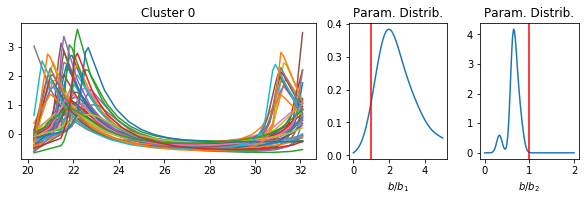

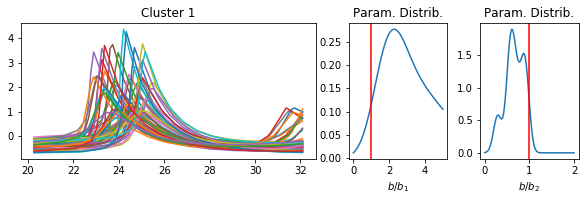

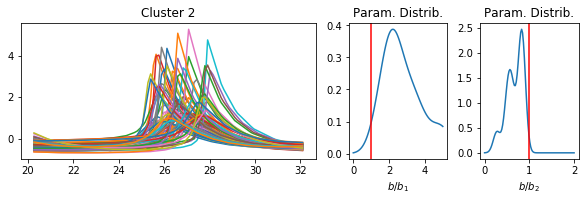

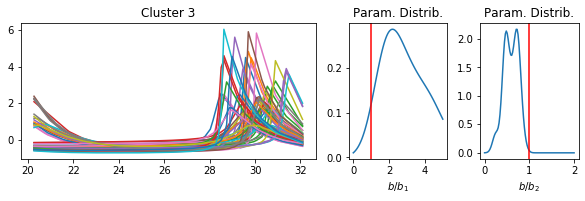

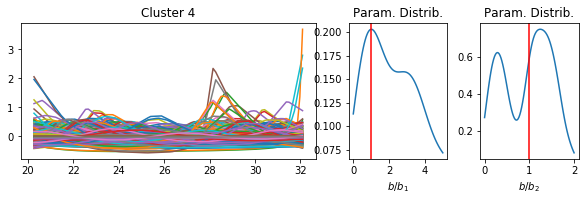

In [21]:
# Plot clusters of predicted time series
for j in range(learn.num_clusters):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,2.5), 
                                        gridspec_kw={'width_ratios': [3,1,1]}) 
    ps = []
    ps2 = []
    for i in range(num_samples):
        if learn.predict_labels[i] == j:
            a = params[i, 0]
            b = params[i, 1]
            b1 = sqrt((1.0-sqrt(1.-8.*a)-2.*a)/2.0)
            b2 = sqrt((1.0+sqrt(1.-8.*a)-2.*a)/2.0)
            ps.append(b/b1)
            ps2.append(b/b2)
            ax1.plot(learn.clean_times, learn.clean_predictions[i, :])
    ax1.set(title='Cluster ' + str(j))
    xs = np.linspace(0.0, 5.0, 100)
    ax2.plot(xs, GKDE(ps)(xs))
    ax2.axvline(1.0, color='r')
    ax2.set(xlabel=r'$b/b_1$', title='Param. Distrib.')
    xs2 = np.linspace(0.0, 2.0, 100)
    ax3.plot(xs2, GKDE(ps2)(xs2))
    ax3.axvline(1.0, color='r')
    ax3.set(xlabel=r'$b/b_2$', title='Param. Distrib.')

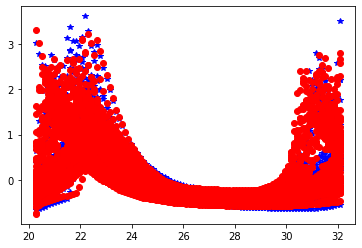

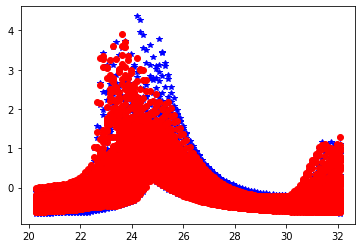

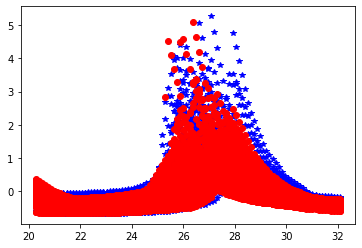

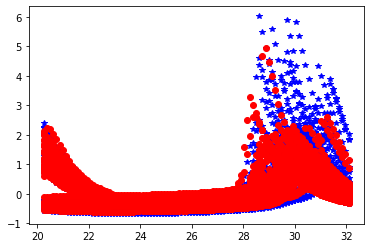

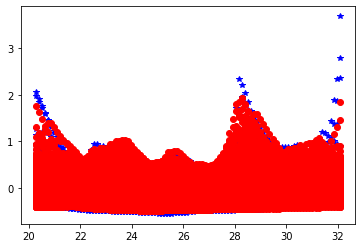

In [22]:
# Plot oberved and predicted clusters
for j in range(learn.num_clusters):
    plt.figure()
    cluster_num = j
    for i in range(num_samples):
        if learn.predict_labels[i] == cluster_num:
            plt.plot(learn.clean_times, learn.clean_predictions[i,:],'b*')
    for i in range(num_obs):
        if learn.obs_labels[i] == cluster_num:
            plt.plot(learn.clean_times, learn.clean_obs[i,:],'ro')

In [24]:
# Find best KPCA transformation for given number of QoI and transform time series data.
predict_map, obs_map = learn.learn_qois_and_transform(num_qoi=3)

3 principal components explain 91.0632% of variance for cluster 0 with {'kernel': 'linear'}
3 principal components explain 56.4596% of variance for cluster 0 with {'kernel': 'rbf'}
3 principal components explain 95.4421% of variance for cluster 0 with {'kernel': 'sigmoid'}
3 principal components explain 71.1953% of variance for cluster 0 with {'kernel': 'poly'}
3 principal components explain 92.5074% of variance for cluster 0 with {'kernel': 'cosine'}
Best kPCA for cluster  0  is  {'kernel': 'sigmoid'}
3 principal components explain 95.4421% of variance.
3 principal components explain 87.7865% of variance for cluster 1 with {'kernel': 'linear'}
3 principal components explain 45.0977% of variance for cluster 1 with {'kernel': 'rbf'}
3 principal components explain 92.7139% of variance for cluster 1 with {'kernel': 'sigmoid'}
3 principal components explain 59.7604% of variance for cluster 1 with {'kernel': 'poly'}
3 principal components explain 86.1858% of variance for cluster 1 with {'ke

In [25]:
# Generate kernel density estimates on new QoI
learn.generate_kdes()
# Calculate rejection rates for each cluster and print averages.
r_vals = learn.compute_r()

Average rejection rates for clusters: [0.8787972812777934, 1.1279826645000277, 1.058591951205604, 1.1205977403311158, 0.8857451505102347]


In [26]:
# Compute marginal probablities for each parameter and initial condition.
param_marginals = []
ic_marginals = []
true_param_marginals = []
true_ic_marginals = []
lam_ptr = []
cluster_weights = []
for i in range(learn.num_clusters):
    lam_ptr.append(np.where(learn.predict_labels == i)[0])
    cluster_weights.append(len(np.where(learn.obs_labels == i)[0]) / num_obs)

for i in range(params.shape[1]):
    true_param_marginals.append(GKDE(params_obs[:,i]))
    param_marginals.append([])
    for j in range(learn.num_clusters):
        param_marginals[i].append(GKDE(params[lam_ptr[j], i], weights=learn.r[j]))
        
for i in range(ics.shape[1]):
    true_ic_marginals.append(GKDE(ics_obs[:,i]))
    ic_marginals.append([])
    for j in range(learn.num_clusters):
        ic_marginals[i].append(GKDE(ics[lam_ptr[j], i], weights=learn.r[j]))

In [27]:
# uniform distribution
def unif_dist(x, p_range):
    y = np.zeros(x.shape)
    val = 1.0/(p_range[1] - p_range[0])
    for i, xi in enumerate(x):
        if xi < p_range[0] or xi >  p_range[1]:
            y[i] = 0
        else:
            y[i] = val
    return y

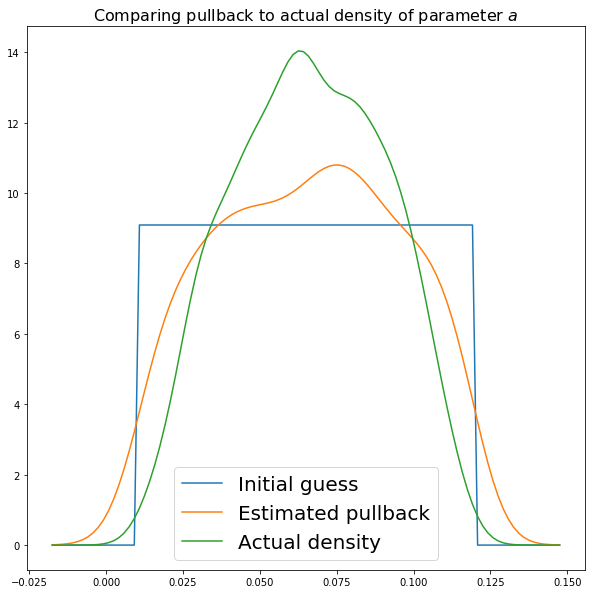

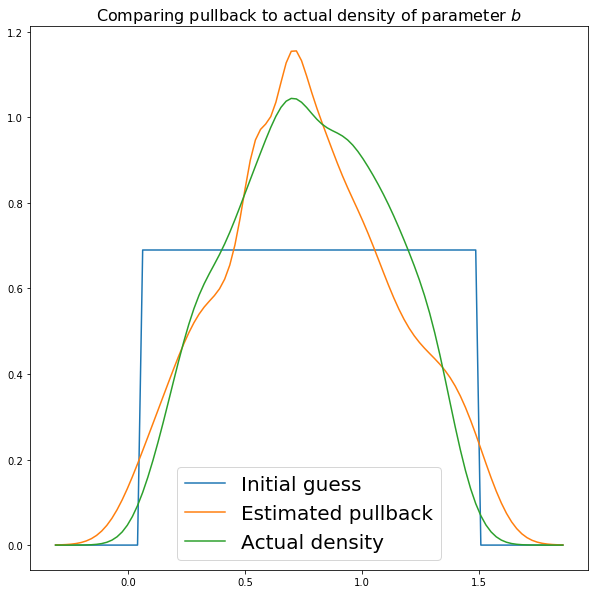

In [28]:
# Plot predicted marginal densities for parameters

for i in range(params.shape[1]):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(params[:, i]), min(params_obs[:, i]))
    x_max = max(max(params[:, i]), max(params_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, param_range[i, :]),
         label = 'Initial guess')
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += param_marginals[i][j](x) * cluster_weights[j]
    plt.plot(x, mar, label = 'Estimated pullback')
    plt.plot(x, true_param_marginals[i](x), label = 'Actual density')
    plt.title('Comparing pullback to actual density of parameter ' + param_labels[i], fontsize=16)
    plt.legend(fontsize=20)

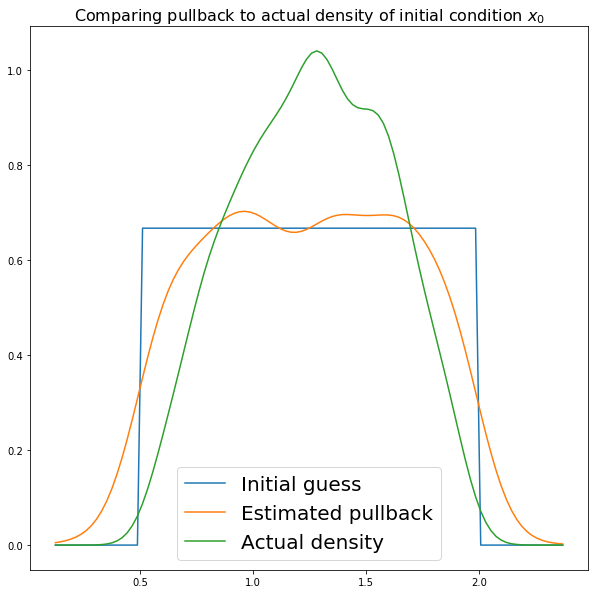

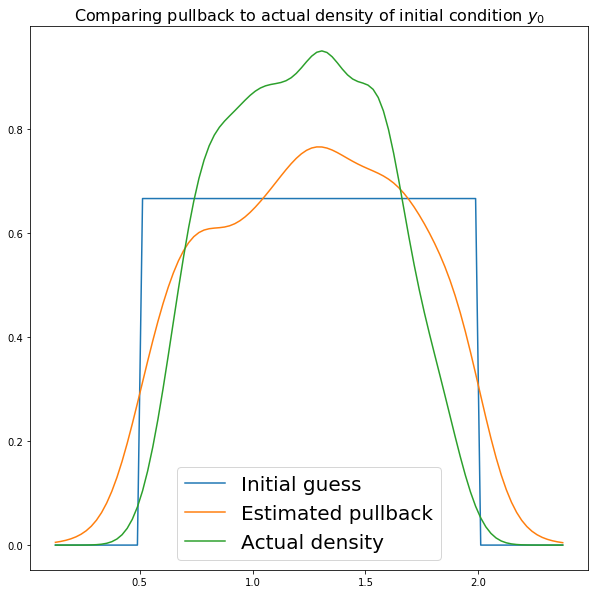

In [29]:
# Plot predicted marginal densities for initial conditions.

for i in range(ics.shape[1]):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(ics[:, i]), min(ics_obs[:, i]))
    x_max = max(max(ics[:, i]), max(ics_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, ic_range[i, :]),
         label = 'Initial guess')
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += ic_marginals[i][j](x) * cluster_weights[j]
    plt.plot(x, mar, label = 'Estimated pullback')
    plt.plot(x, true_ic_marginals[i](x), label = 'Actual density')
    plt.title('Comparing pullback to actual density of initial condition ' + ic_labels[i], fontsize=16)
    plt.legend(fontsize=20)